# Movie Analysis by Genre

Chau Nguyen and Brad Johnson<br />
Flatiron School-DC Data Science 100719 Cohort<br />
Module 1 Project 1

# Table of Contents
1. [Clean data](#clean-data)
1. [Break out individual genres](#break-out-genres)


Import standard libraries:

In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Import custom libraries:

In [528]:
import movie_data as md
import split_data_fields as sdf

Set plotting options:

In [ ]:
sns.set_context('poster')
sns.set(rc={'figure.figsize':(14,8)})
sns.set_style('whitegrid')

## Import and clean data <a class="anchor" id="clean-data"></a>

Tables of interest:
* `imdb.title.basics`  (for genres)
* `imdb.title.ratings` (for average ratings)
* `tn.movie_budgets` (for budgets and worldwide gross)

`md.generate_movie_analysis_df()` uses functions from the custom `data_cleaning` library.

Data attributes and data-cleaning settings are stored in the `TABLE_FORMATS` dict in `data_cleaning`.

* **Importing**: function `df_from_movie_csv` loads csv.gz by tablename into dataframe, setting index, converting date fields to date time, converting dollar fields to numeric.
* **Cleaning**: function `clean_movie_df` standardizes field names, adds a `year` column if appropriate, filters results to 2010-2018, and normalizes dollar fields to millions.
* **Deduping**: function `select_max_rows_on_key_column` picks the entries by `title` with max `numvotes`
* **Merging**: function `join_dfs_on_key_col` joins the dataframes on `title`
* **Calculating**:
 * `profit` = `worldwide_gross` - `production_budget`
 * `roi` = `profit` / `production_budget`



In [430]:
df = md.generate_movie_analysis_df()

Importing tables into dataframes...
Cleaning data...
Merging IMDB data...
Deduping IMDB data...
Merging TheNumbers data...
Calculating profit and ROI


### Table: Summary of our movie dataset

In [433]:
df.describe()

,start_year,runtime_minutes,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,year,profit,roi
count,1750.000000,1743.000000,1742.000000,1.742000e+03,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000
mean,2013.632000,106.172691,6.262801,1.040751e+05,38.226549,47.611831,119.641575,2013.788000,81.415025,2.392184
std,2.405089,17.759023,1.069533,1.568357e+05,52.648305,79.954285,219.173274,2.383998,179.751048,11.494607
min,2010.000000,12.000000,1.600000,6.000000e+00,0.001400,0.000000,0.000000,2010.000000,-110.450242,-1.000000
25%,2012.000000,94.000000,5.700000,9.116500e+03,4.712500,0.351123,1.860575,2012.000000,-1.399592,-0.697032
50%,2014.000000,104.000000,6.400000,4.726050e+04,18.000000,17.734367,34.951873,2014.000000,12.667179,0.727687
75%,2015.000000,116.000000,7.000000,1.240532e+05,45.000000,56.974742,126.874641,2016.000000,78.714168,2.644018
max,2019.000000,180.000000,8.800000,1.841066e+06,410.600000,700.059566,2048.134200,2018.000000,1748.134200,415.564740


There are 1750 movies from 2010-2018 in the clean dataset. `production_budget`, `domestic_gross`, `worldwide_gross`
and `profit` are in millions of dollars. `roi` is dimensionless.

## Break out individual genres <a class="anchor" id="break-out-genres"></a>

Multiple genres are assigned to a given title in the dataset (e.g. `action,adventure,animation`). 

To analyze genres independently, we generate a new dataframe with a distinct row for each genre per title using the custom `split_data_fields` (`sdf`) library.

Function `sdf.multifield_to_col` returns a dataframe containing multiple rows for a given title, one for each genre in its genres list.

In [503]:

expand_df = sdf.multifield_to_col(df, 'tconst', 'genres')

### Plot: Count of movies associated with an individual genre

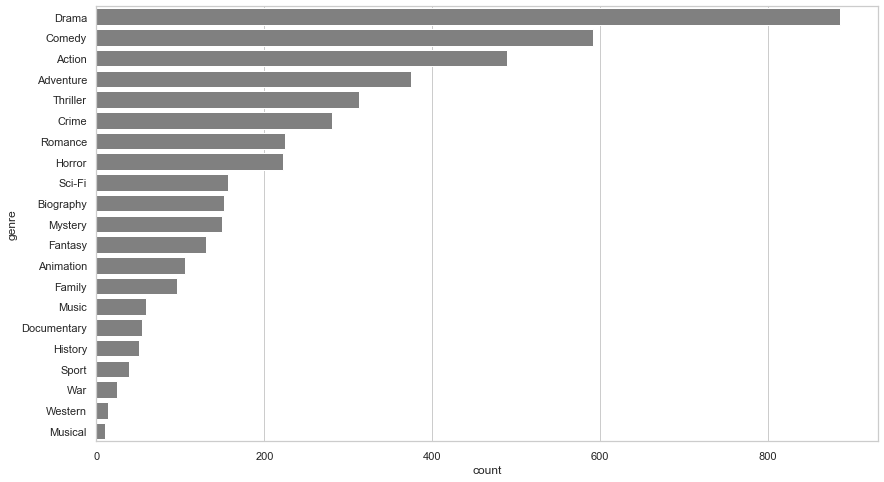

In [504]:
sns.countplot(y='genre',data=full_expand_df,
              order=full_expand_df.genre.value_counts().index,
              color="grey");

We first conducted an analysis of the dataset looking at all genres. For our final presentation, we decided to explore the genres that were most commonly produced in order to narrow our analysis. 

We chose a minimum of 100 movies per genre as our cut-off.

## Filter genres to those associated with over 100 movies

To 

In [506]:
def filter_df_by_field_count(dframe,field,count):
    return dframe[dframe[field].isin(dframe[field].value_counts()[lambda ct: ct >= 100].index)]

clip_df = filter_df_by_field_count(expand_df,'genre',100)

In [532]:
if (1==1) and 
   (2==2):
        print(3)

SyntaxError: invalid syntax (<ipython-input-532-f3d1750ff1ae>, line 1)

In [507]:
full_expand_df = expand_df.copy()
expand_df = clip_df

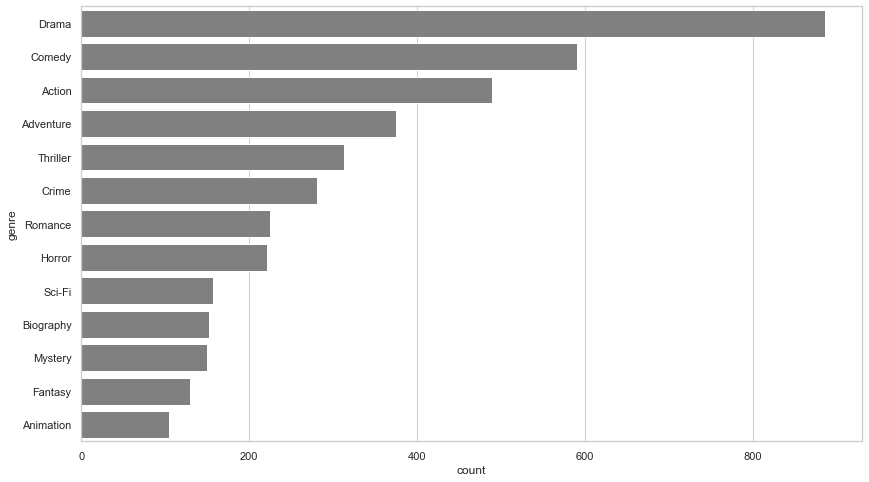

In [508]:
sns.countplot(y='genre',data=expand_df,
              order=expand_df.genre.value_counts().index,
              color="grey");

## Genre vs. worldwide gross

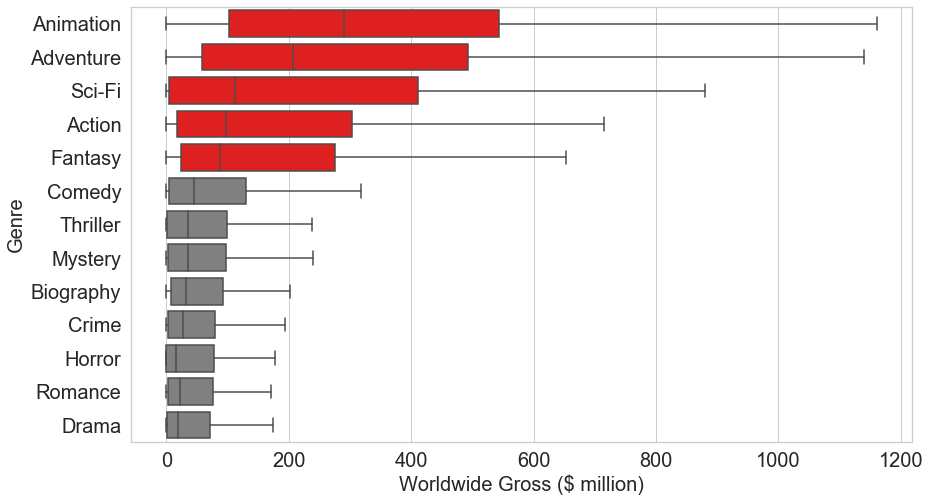

In [509]:
mc.make_genre_boxplot(expand_df,'worldwide_gross',value_num=13,
                   highlight_list=['Action','Adventure','Sci-Fi','Animation','Fantasy'],
                   xlabel='Worldwide Gross ($ million)',
                   ylabel='Genre');

## Genre vs. budget

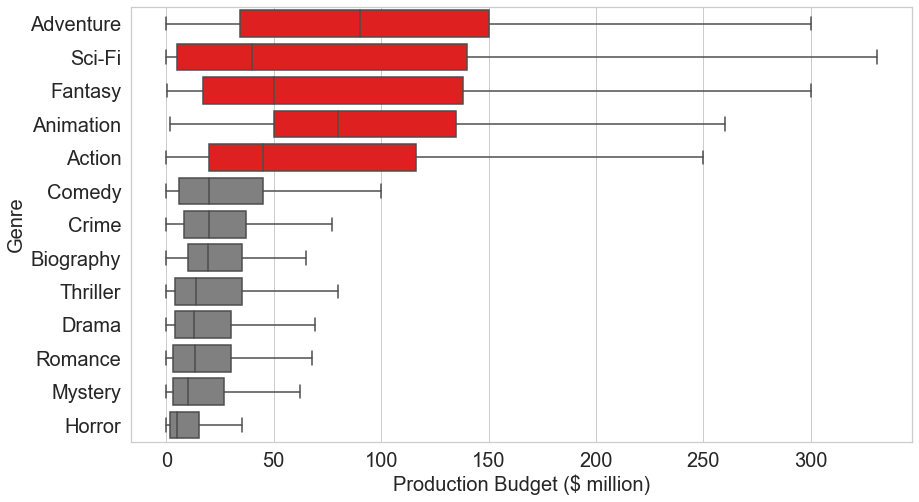

In [494]:
mc.make_genre_boxplot(expand_df,'production_budget',value_num=13,
                   highlight_list=['Action','Adventure','Sci-Fi','Animation','Fantasy'],
                   xlabel='Production Budget ($ million)',
                   ylabel='Genre');

## Genre vs. profit

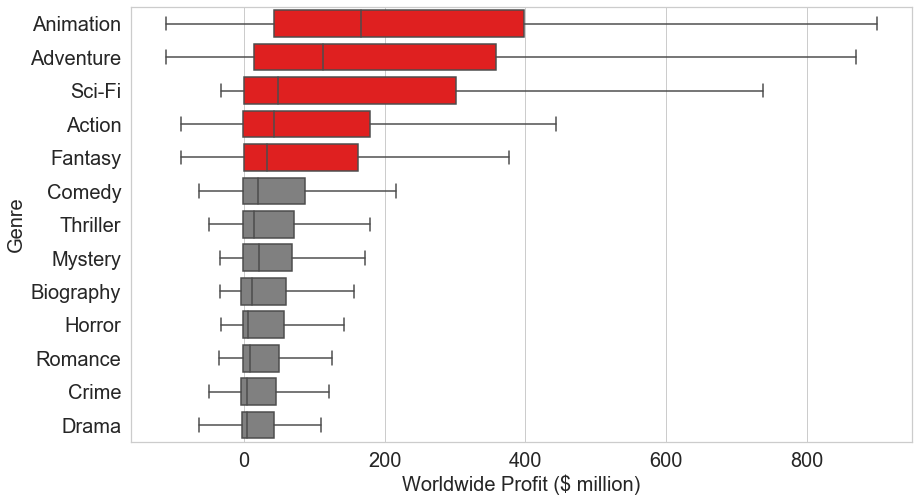

In [510]:
import movie_charts as mc
importlib.reload(mc)
mc.make_genre_boxplot(expand_df,'profit',value_num=13,
                      highlight_list=['Action','Adventure','Sci-Fi','Animation','Fantasy'],
                   	  xlabel='Worldwide Profit ($ million)',
                      ylabel='Genre')

## Genre vs. ROI

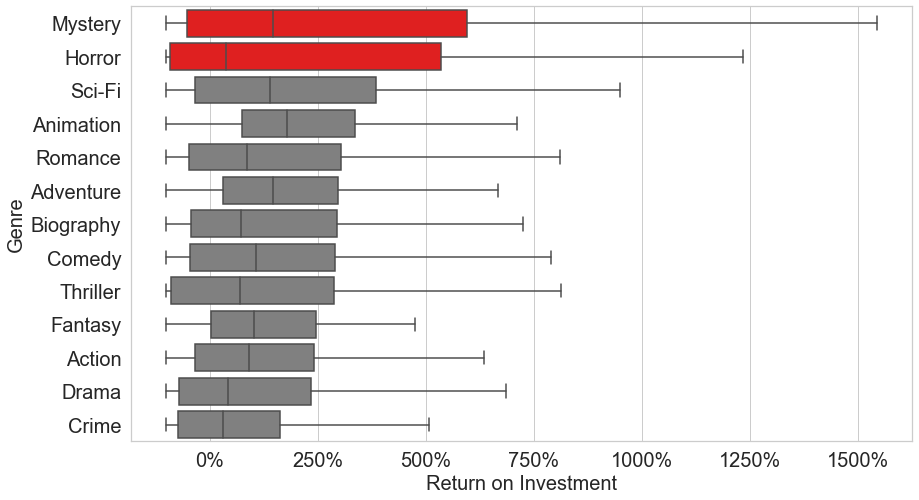

In [492]:
mc.make_genre_boxplot(expand_df,'roi',value_num=13,
                   highlight_list=['Horror','Mystery'],
                   xlabel='Return on Investment',
                   ylabel='Genre',
                   formatx_as_percent=True);

# Scatterplot of ROI vs budget colored by genre

In [451]:
expand_df['horror'] = np.where(expand_df['genre']=='Horror', 'Horror', 'Not Horror')

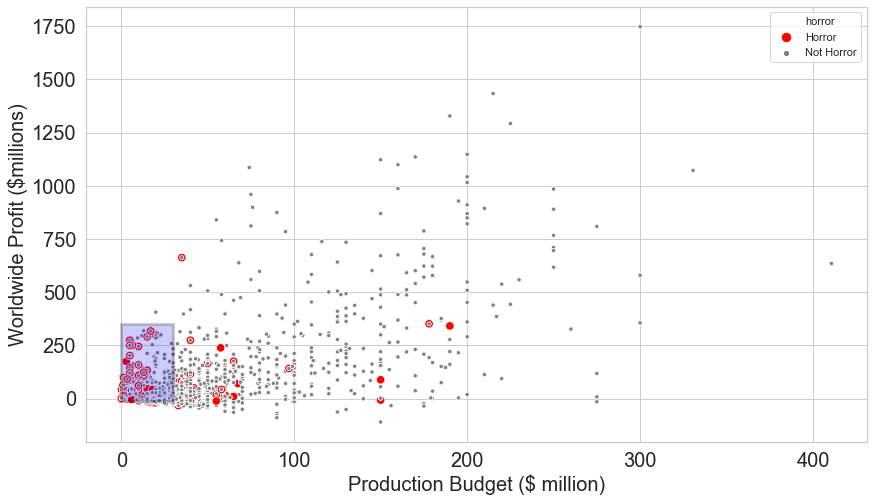

In [459]:
import matplotlib.patches as patches
sns.set(rc={'figure.figsize':(14,8)})
sns.set_style('whitegrid')

genre_list = expand_df.groupby('genre').max().sort_values(ascending=False, 
                                                   by='roi')[:13].index.to_list()
palette = ['gray']*10
palette[0]='red'
splot = sns.scatterplot(data=expand_df[expand_df['genre'].isin(genre_list)],
                        x='production_budget',
                        y='profit',
                        hue='horror',
                        size='horror',
                        palette=['red','gray'],
                        hue_order=['Horror','Not Horror'],
                        size_order=['Horror','Not Horror'])
splot.set_xlabel("Production Budget ($ million)",fontsize=20)
splot.set_ylabel("Worldwide Profit ($millions)",fontsize=20)
splot.tick_params(labelsize=20)
#plt.xlim(None,300)
#plt.ylim(None,1000)
splot.add_patch(patches.Rectangle((0, -10), # (x,y)
                                    30, # width
                                    360, # height
                                    alpha=0.2, 
                                    facecolor="blue",
                                    edgecolor="black", 
                                    linewidth=3,
                                    linestyle='solid'));


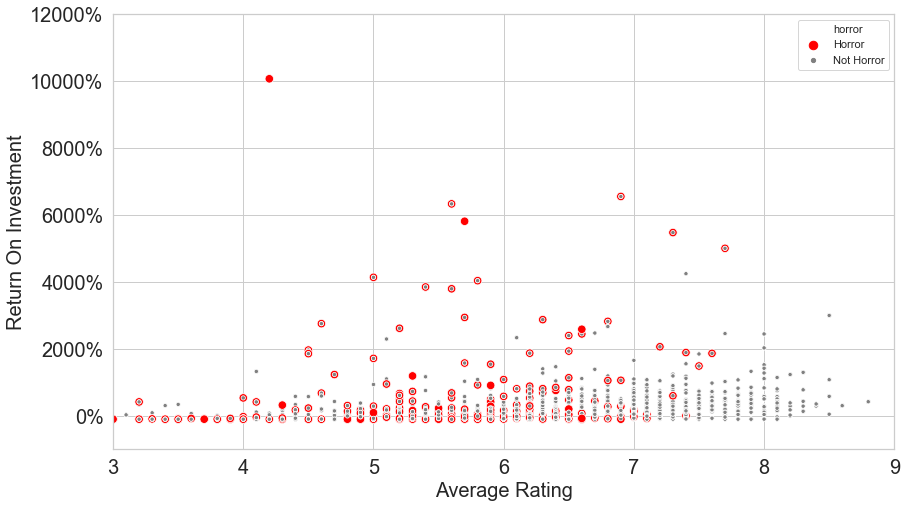

In [460]:
genre_list = expand_df.groupby('genre').max().sort_values(ascending=False, 
                                                   by='roi')[:13].index.to_list()
palette = ['gray']*10
palette[0]='red'
splot = sns.scatterplot(data=expand_df[expand_df['genre'].isin(genre_list)],
                        x='averagerating',
                        y='roi',
                        hue='horror',
                        size='horror',
                        palette=['red','gray'],
                        hue_order=['Horror','Not Horror'],
                        size_order=['Horror','Not Horror'])
splot.set_xlabel("Average Rating",fontsize=20)
splot.set_ylabel("Return On Investment",fontsize=20)
splot.tick_params(labelsize=20)
plt.xlim(3,9)
plt.ylim(-10,120)
splot.set_yticklabels(['{0:.0%}'.format(x) for x in splot.get_yticks()]);

# Top movies

In [516]:
# by genre movie with max profit

top_list = expand_df.reset_index().groupby('genre').max()['profit'].reset_index()

expand_df[]

,genre,profit
0,Action,1748.134200
1,Adventure,1748.134200
2,Animation,1122.469910
3,Biography,839.985342
4,Comedy,1122.469910
5,Crime,1328.722794
6,Drama,839.985342
7,Fantasy,1099.199706
8,Horror,662.457969
9,Mystery,506.464305


In [525]:
expand_df[expand_df.groupby('genre')['profit'].transform(max) == expand_df['profit']].sort_values('profit',ascending=False)

,title,original_title,start_year,runtime_minutes,averagerating,numvotes,release_date,production_budget,domestic_gross,worldwide_gross,year,profit,roi,genre
tconst,,,,,,,,,,,,,,
tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,8.5,670926.0,2018-04-27,300.0,678.815482,2048.134200,2018,1748.134200,5.827114,Action
tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,8.5,670926.0,2018-04-27,300.0,678.815482,2048.134200,2018,1748.134200,5.827114,Adventure
tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,8.5,670926.0,2018-04-27,300.0,678.815482,2048.134200,2018,1748.134200,5.827114,Sci-Fi
tt2820852,Furious 7,Furious Seven,2015,137.0,7.2,335074.0,2015-04-03,190.0,353.007020,1518.722794,2015,1328.722794,6.993278,Crime
tt2820852,Furious 7,Furious Seven,2015,137.0,7.2,335074.0,2015-04-03,190.0,353.007020,1518.722794,2015,1328.722794,6.993278,Thriller
tt2294629,Frozen,Frozen,2013,102.0,7.5,516998.0,2013-11-22,150.0,400.738009,1272.469910,2013,1122.469910,7.483133,Animation
tt2294629,Frozen,Frozen,2013,102.0,7.5,516998.0,2013-11-22,150.0,400.738009,1272.469910,2013,1122.469910,7.483133,Comedy
tt2771200,Beauty and the Beast,Beauty and the Beast,2017,129.0,7.2,238325.0,2017-03-17,160.0,504.014165,1259.199706,2017,1099.199706,6.869998,Fantasy
tt1727824,Bohemian Rhapsody,Bohemian Rhapsody,2018,134.0,8.0,345466.0,2018-11-02,55.0,216.303339,894.985342,2018,839.985342,15.272461,Biography


# Looking at genre combinations

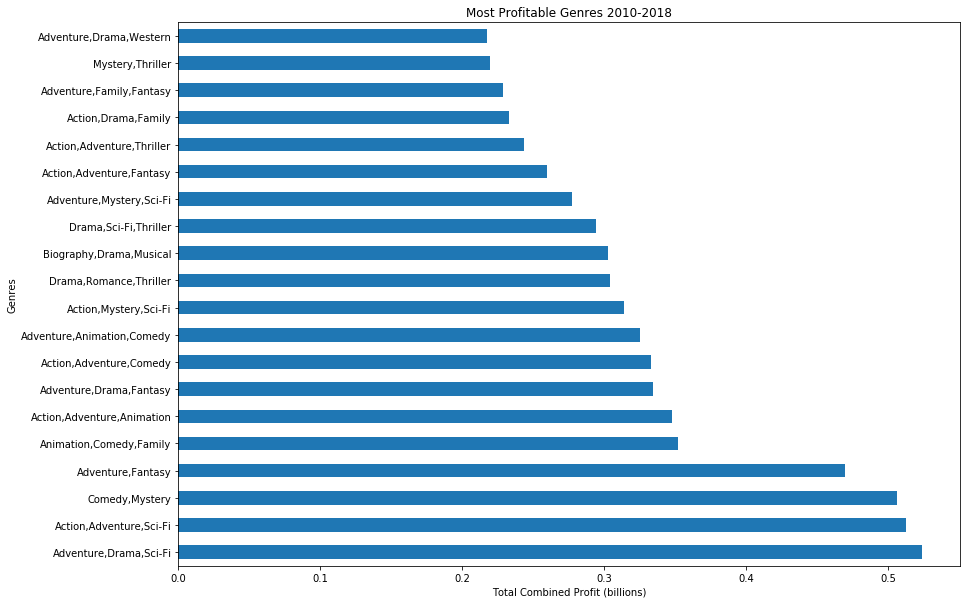

In [15]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

df.groupby('genres').sum().sort_values(ascending=False, 
                                                   by='profit')['profit'][:20].div(1000).plot.barh()

ax.set_xlabel('Total Combined Profit (billions)')
ax.set_ylabel('Genres')
ax.set_title('Most Profitable Genres 2010-2018');


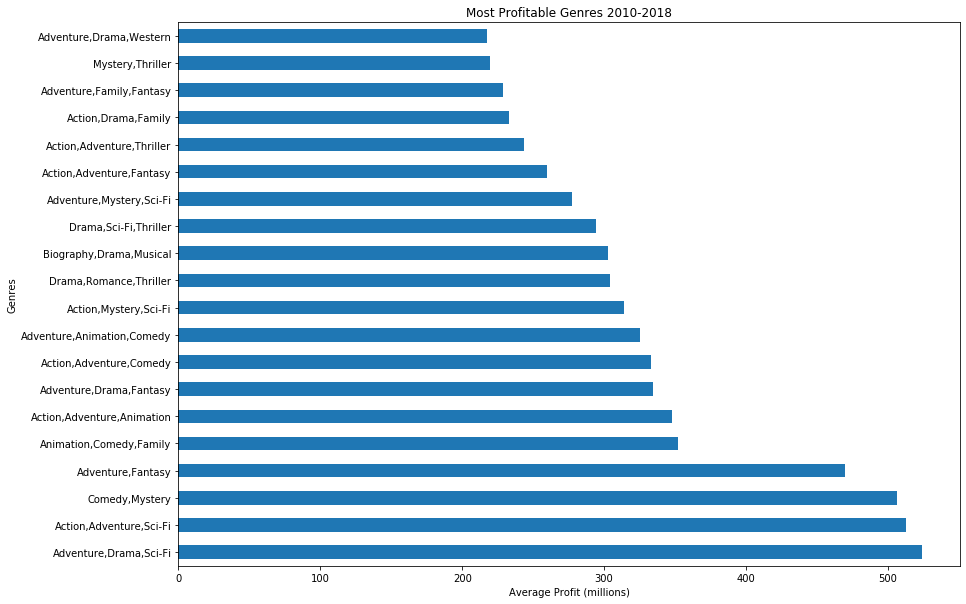

In [16]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

df.groupby('genres').mean().sort_values(ascending=False, 
                                                   by='profit')['profit'][:20].plot.barh()

ax.set_xlabel('Average Profit (millions)')
ax.set_ylabel('Genres')
ax.set_title('Most Profitable Genres 2010-2018');

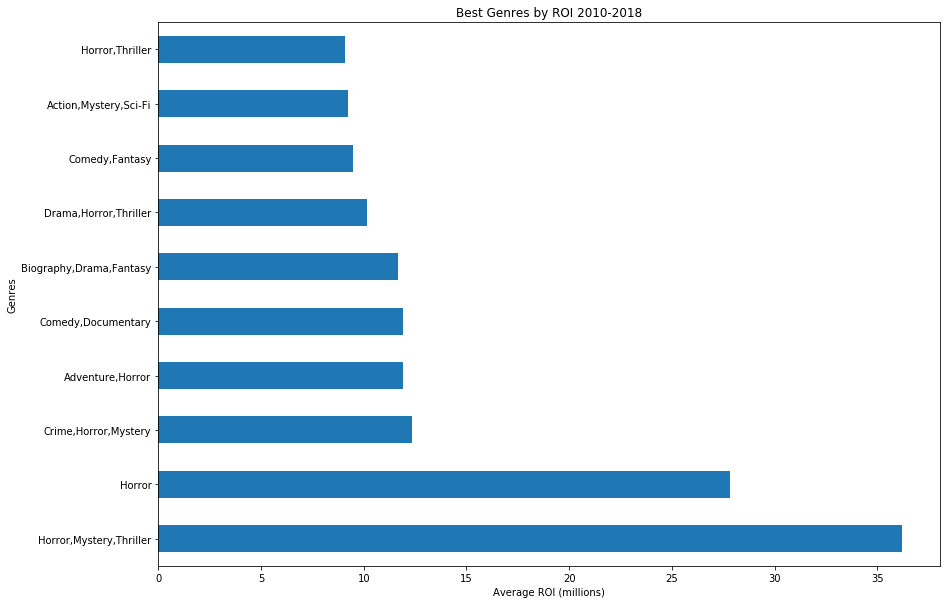

In [18]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

df.groupby('genres').mean().sort_values(ascending=False, 
                                                   by='roi')['roi'][:10].plot.barh()

ax.set_xlabel('Average ROI (millions)')
ax.set_ylabel('Genres')
ax.set_title('Best Genres by ROI 2010-2018');